# Bayesian inference for Poisson Processes

Simplest case : perform Bayesian inference for simulated HPP.

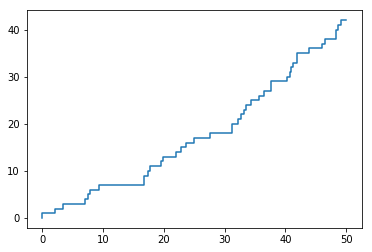

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
%matplotlib inline

# Plot realization of unit rate Poisson process.
Lambda, T, t_curr = 1, 50, 0
N_t = np.array([0])
arrivals = [0]
while t_curr <  T:
    random_arrival = expon.rvs(scale=1/Lambda, size=1)[0]
    arrivals.append(random_arrival+arrivals[-1])
    N_t = np.append(N_t, N_t[-1]+1)
    t_curr += random_arrival
plt.step(arrivals, N_t)

Assume $\text{Gamma}(\alpha, \beta)$ prior, then posterior is $\text{Gamma}(\alpha+n, \beta+T)$, $T=50$.

Text(0.5,1,'Gamma(100, 50) prior')

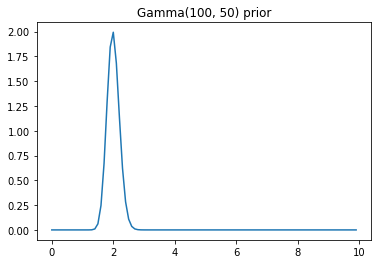

In [2]:
from scipy.stats import gamma

prior_alpha, prior_beta= 100, 50
xvals = np.arange(0,10,0.1)
yvals = gamma.pdf(xvals, a=prior_alpha, scale=1/prior_beta)
plt.plot(xvals, yvals)
plt.title('Gamma({}, {}) prior'.format(prior_alpha, prior_beta))

Text(0.5,1,'Gamma(149, 100) posterior')

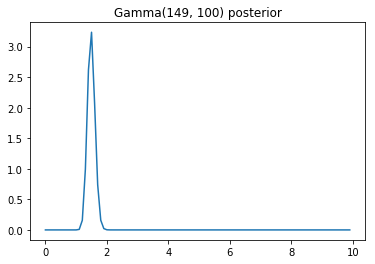

In [4]:
post_alpha, post_beta= prior_alpha + N_t[-1], prior_beta + T 
xvals = np.arange(0,10,0.1)
yvals = gamma.pdf(xvals, a=post_alpha, scale=1/post_beta)
plt.plot(xvals, yvals)
plt.title('Gamma({}, {}) posterior'.format(post_alpha, post_beta))

Generate an inhomogeneous Poisson process of rate $\lambda(t)=a e^{-bt}$, and estimate parameters $a$ and $b$ in a Bayesian framework. NHPP is simulated by the thinning algorithm in Lewis & Schedler, 1979.

Text(0.5,1,'NHPP : $\\lambda(t) = ae^{-bt}$')

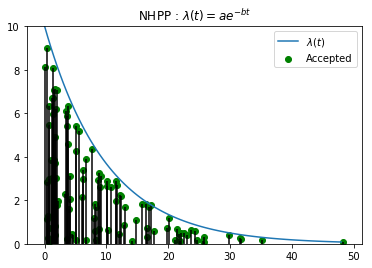

In [3]:
from scipy.stats import uniform

def NHPP_lambda(a, b, t): # intensity function for NHPP as in example 2.3 in Insua et al, 2012.
    return a*np.exp(-b*t)

a, b = 10, 0.1
# T=50 as before
M = a
t = 0
T=50
arrivals, N_t, unifs = [], [], []
while t < T:
    #E = expon.rvs(scale=1/M,size=1)[0]
    E = np.random.exponential(scale=1/M)
    t += E
    U = uniform.rvs(loc=0, scale=M)
    if t < T and U <= NHPP_lambda(a,b,t):
        arrivals.append(t)
        unifs.append(U)
        if len(N_t)==0:
            N_t.append(1)
        else:
            N_t.append(N_t[-1]+1)
tvals = np.arange(0, arrivals[-1], 0.5)
plt.plot(tvals, NHPP_lambda(a, b, tvals), label='$\lambda(t)$')
plt.scatter(arrivals, unifs, label='Accepted', c='green')
for i in range(len(unifs)):
    plt.vlines(x = arrivals[i], ymin=0, ymax=unifs[i])
plt.legend(loc='best')
plt.ylim(0, M)
plt.title('NHPP : $\lambda(t) = ae^{-bt}$')

First do one parameter case : $\lambda(t) = e^{-bt}$.

Works ! The expression for posterior of $b$ is:

$$p(b | \{t_{n}\}) \propto b^{\alpha-1} \cdot \exp \Big[ -\beta b + \frac{3}{b}(e^{-bT}-1) - b\sum_{i=1}^{n}t_{i}\Big]$$

Text(0.5,1,'Samples of a, mean : 9.952')

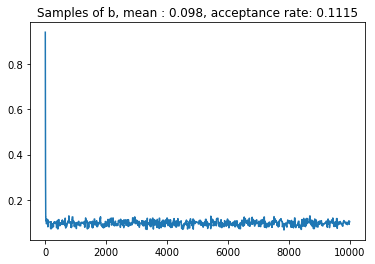

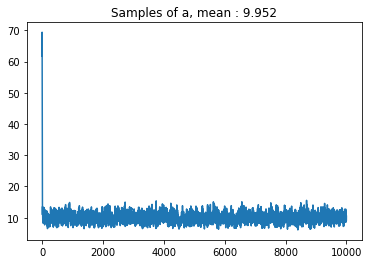

In [4]:
# Now sample both parameters a and b using systematic scan Gibbs sampler.

from scipy.stats import truncnorm,norm

N = 10000

def log_posterior_b(a, b, alpha, beta, arrivals, T):
    return -beta*b+(a/b)*(np.exp(-b*T)-1)-b*np.sum(arrivals)+(alpha-1)*np.log(b)

samples_of_b , samples_of_a = [], []
alpha1, beta1 = 6, 2/3
alpha2, beta2 = 4, 8
curr_b = gamma.rvs(a=alpha2, scale=1/beta2)
curr_a = gamma.rvs(a = alpha1+len(arrivals), scale = 1/(beta1+ (1/curr_b)*(1-np.exp(-curr_b*T))))
accepted_b = 0
lower, upper = 0, 100
scale_b = 0.1

for i in range(N):
    new_a = gamma.rvs(a = alpha1+len(arrivals), scale = 1/(beta1+ (1/curr_b)*(1-np.exp(-curr_b*T))))
    lower_curr, upper_curr = (lower-curr_b)/scale_b, (upper-curr_b)/scale_b
    cand_b = truncnorm.rvs(a=lower_curr, b=upper_curr, loc=curr_b, scale=scale_b)
    lower_cand, upper_cand = (lower-cand_b)/scale_b, (upper-cand_b)/scale_b
    log_prop_at_cand = truncnorm.logpdf(cand_b, a=lower_curr, b=upper_curr, loc=curr_b, scale=scale_b)
    log_prop_at_curr = truncnorm.logpdf(curr_b, a=lower_cand, b=upper_cand, loc=cand_b, scale=scale_b)
    log_posterior_at_curr = log_posterior_b(new_a, curr_b, alpha2, beta2, arrivals, T)
    log_posterior_at_cand = log_posterior_b(new_a, cand_b, alpha2, beta2, arrivals, T)
    ratio = min(0, log_posterior_at_cand +log_prop_at_curr - log_posterior_at_curr - log_prop_at_cand)
    U = uniform.rvs()
    if U <= np.exp(ratio):
        curr_b = cand_b
        accepted_b += 1
    curr_a = new_a
    samples_of_a.append(curr_a)
    samples_of_b.append(curr_b)
plt.plot(range(N), samples_of_b)
plt.title('Samples of b, mean : {}, acceptance rate: {}'.format(round(np.mean(samples_of_b),3), accepted_b/N))
plt.figure()
plt.plot(range(N), samples_of_a)
plt.title('Samples of a, mean : {}'.format(round(np.mean(samples_of_a[int(N/3):]),3)))

(5, 16)

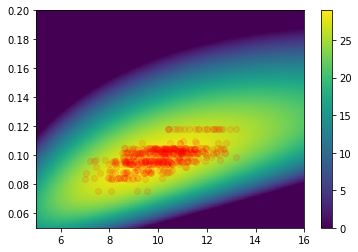

In [5]:
def joint(a, b, alpha1, beta1, alpha2, beta2, arrivals, T):
    return (np.exp(-b*T)-1)*a/b - b*np.sum(arrivals)+len(arrivals)*np.log(
        a)+gamma.logpdf(a, a=alpha1, scale=1/beta1)+gamma.logpdf(b, a=alpha2, scale=1/beta2)
    
a, b = np.linspace(5,16,500), np.linspace(0.05, 0.20, 500)
A, B = np.meshgrid(a,b)
Z = joint(A,B, alpha1, beta1, alpha2, beta2, arrivals, T)
plt.pcolormesh(A,B,Z, vmin=0)
plt.colorbar()
plt.scatter(samples_of_a[-500:], samples_of_b[-500:], alpha=0.1, c='red')
joint(10, 0.2 , alpha1, beta1, alpha2, beta2, arrivals, T)
plt.xlim(5,16)
#plt.plot(np.log(np.array(samples_of_b)), np.log(np.array(samples_of_a)))

## Simulate a Hawkes process

Intensity function will be of form:

$$\lambda^{*}(t) = \lambda + a\sum_{t_{i}<t} b \cdot e^{-b(t-t_{i})}$$

Thus the likelihood is given by:

$$ L(\lambda, a, b | \{t_{n}\}) \propto \exp\Big(-\int_{0}^{T}\lambda^{*}(t)dt\Big)
\prod_{i=1}^{N} \lambda^{*}(t_{i})$$

$$ = \exp\Big(-\int_{0}^{T}\big(\lambda + a\sum_{t_{i}<t}b\cdot e^{-b(t-t_{i})}\big)dt\Big)
\prod_{j=1}^{N} \big(\lambda + a\sum_{i=1}^{i-1}b\cdot e^{-b(t_{j}-t_{i})}\big)$$

where $N$ is the number of arrivals (i.e. spikes). Simulate a Hawkes process using thinning, with parameters $\lambda = 1, a=0.5, b=5.$

Text(0,0.5,'$\\lambda(t)$')

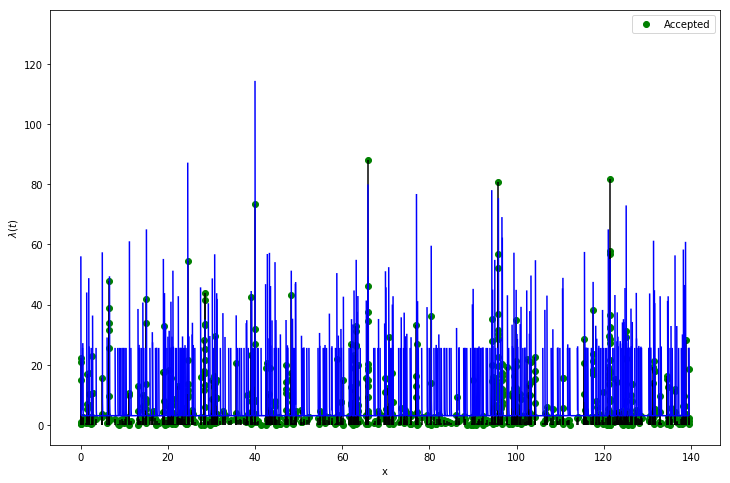

In [6]:
lmbd, a, b = 3.1, 0.46, 48.4

def Hawkes_CIF(lmbd, a, b, arrivals, t):
    f = lambda t,arriv : a*b*np.exp(-b*(t-arriv))
    return lmbd + np.sum(f(np.ones(len(arrivals),)*t, arrivals))

t, T, simulated_Hawkes, unifs = 0, 140, [], []
eps = 10**(-10)
while t < T:
    M = Hawkes_CIF(lmbd, a, b, simulated_Hawkes, t+eps)
    E = np.random.exponential(scale=1/M)
    t += E
    U = uniform.rvs(loc=0, scale=M)
    if t<T and U <= Hawkes_CIF(lmbd, a, b, simulated_Hawkes, t):
        simulated_Hawkes.append(t)
        unifs.append(U)
plt.figure(figsize=(12,8))
#tvals = np.arange(0, arrivals[-1], 0.5)
plt.scatter(simulated_Hawkes, unifs, label='Accepted', c='green')
for i in range(len(unifs)):
    plt.vlines(x = simulated_Hawkes[i], ymin=0, ymax=unifs[i])
tvals_for_base = np.arange(0, simulated_Hawkes[0], 0.05)
plt.plot(tvals_for_base, np.ones(len(tvals_for_base),)*lmbd, color='blue')
for k in range(len(simulated_Hawkes)-1):
    tvals_per_arrival = np.arange(simulated_Hawkes[k], simulated_Hawkes[k+1], 0.05)
    lambda_vals = [Hawkes_CIF(lmbd, a, b, simulated_Hawkes[:k+1], tvals_per_arrival[j]) for j in range(len(tvals_per_arrival))]
    plt.plot(tvals_per_arrival, lambda_vals, color='blue')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel(r'$\lambda(t)$')

In [14]:
# Perform Bayesian inference on parameter lmbd, a, b using Metropolis within Gibbs sampler.
# Write all functions in this block!!

import warnings
from scipy.stats import truncnorm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.optimize import minimize

def log_prod_CIF(lmbd, a, b, arrivals):
        return np.sum([np.log(Hawkes_CIF(lmbd, a, b, arrivals[:j], arrivals[j])) for j in range(len(arrivals))])

def log_exp_term(a, b, T, arrivals):
    return -a*len(arrivals) + a*np.sum([np.exp(-b*(T-arr)) for arr in arrivals])


def Hawkes_MH_within_Gibbs(T, arrivals, scale_lmbd, scale_a, scale_b, N, alpha_lmbd=3/2, beta_lmbd=1, alpha_b=4, beta_b=1/2):

    scales = [1e-2, 0.05, 0.1, 0.5, 1, 2.5, 5, 10]
    scales_b = [3]
    # Use truncated normal as proposal distribution for MH.
    lower, upper = 0, 100 # use these for all three parameters.
    
    # Sample the initial values
    curr_lmbd, curr_a, curr_b = gamma.rvs(a=alpha_lmbd, scale=1/beta_lmbd), uniform.rvs(), gamma.rvs(a=alpha_b,scale=1/beta_b)
    
    samples_of_lmbd, samples_of_a, samples_of_b = [], [], []
    accepted_lmbd, accepted_a, accepted_b = 0.0, 0.0, 0.0
    log_likelihood = []
    
    # For truncated normal
    def prop_bounds(lower, upper, mean, sd):
        return (lower-mean)/sd, (upper-mean)/sd

    for i in range(N):
        try:
            curr_log_likelihood = -curr_lmbd*T+log_exp_term(curr_a, curr_b, T, arrivals)+log_prod_CIF(curr_lmbd, 
                                                   curr_a, curr_b, arrivals)
            log_likelihood.append(curr_log_likelihood)
            #scale_lmbd = np.random.choice(scales)
            lower_curr, upper_curr = prop_bounds(lower, upper, curr_lmbd, scale_lmbd)
            #cand_lmbd = truncnorm.rvs(a=lower_curr, b=upper_curr, loc=curr_lmbd, scale=scale_lmbd)
            cand_lmbd = norm.rvs(loc=0, scale=scale_lmbd) + curr_lmbd
            lower_cand, upper_cand = prop_bounds(lower, upper, cand_lmbd, scale_lmbd)
            if cand_lmbd>0:
                lmbd_pdf_at_curr = -curr_lmbd*T+log_prod_CIF(curr_lmbd, curr_a, curr_b, arrivals)+gamma.logpdf(curr_lmbd,
                                                                                                       a=alpha_lmbd, scale=1/beta_lmbd)
                lmbd_pdf_at_cand = -cand_lmbd*T+log_prod_CIF(cand_lmbd, curr_a, curr_b, arrivals)+gamma.logpdf(cand_lmbd,
                                                                                                       a=alpha_lmbd, scale=1/beta_lmbd)
#                 prop_at_curr = truncnorm.pdf(curr_lmbd, a=lower_cand, b=upper_cand, loc=cand_lmbd, scale=scale_lmbd)
#                 prop_at_cand = truncnorm.pdf(cand_lmbd, a=lower_curr, b=upper_curr, loc=curr_lmbd, scale=scale_lmbd)
#                 ratio1 = min(0, lmbd_pdf_at_cand + np.log(prop_at_curr) - lmbd_pdf_at_curr - np.log(prop_at_cand))
                ratio1 = min(0, lmbd_pdf_at_cand - lmbd_pdf_at_curr)
                U = uniform.rvs()
                if U <= np.exp(ratio1):
                    curr_lmbd = cand_lmbd
                    accepted_lmbd += 1
            samples_of_lmbd.append(curr_lmbd)

            # Next update a
            lower_curr, upper_curr = prop_bounds(lower, upper, curr_a, scale_a)
            #cand_a = truncnorm.rvs(a=lower_curr, b=upper_curr, loc=curr_a, scale=scale_a)
            cand_a = norm.rvs(loc=0, scale=scale_a) + curr_a
            lower_cand, upper_cand = prop_bounds(lower, upper, cand_a, scale_a)
            if cand_a > 0:
                a_pdf_at_curr = log_exp_term(curr_a, curr_b, T, arrivals)+log_prod_CIF(
                    curr_lmbd, curr_a, curr_b, arrivals) + uniform.logpdf(curr_a)
                a_pdf_at_cand = log_exp_term(cand_a, curr_b, T, arrivals)+log_prod_CIF(
                    curr_lmbd, cand_a, curr_b, arrivals) + uniform.logpdf(cand_a)
        #             prop_at_curr = truncnorm.pdf(curr_a, a=lower_cand, b=upper_cand, loc=cand_a, scale=scale_a)
        #             prop_at_cand = truncnorm.pdf(cand_a, a=lower_curr, b=upper_curr, loc=curr_a, scale=scale_a)
        #             ratio2 = min(0, a_pdf_at_cand + np.log(prop_at_curr) - a_pdf_at_curr - np.log(prop_at_cand))
                ratio2 = min(0, a_pdf_at_cand - a_pdf_at_curr)
                U = uniform.rvs()
                if U <= np.exp(ratio2):
                    curr_a = cand_a
                    accepted_a += 1
            samples_of_a.append(curr_a)

            # Update b
            lower_curr, upper_curr = prop_bounds(lower, upper, curr_b, scale_b)
            #cand_b = truncnorm.rvs(a=lower_curr, b=upper_curr, loc=curr_b, scale=scale_b)
            cand_b = norm.rvs(loc=0, scale=scale_b) + curr_b
            lower_cand, upper_cand = prop_bounds(lower, upper, cand_b, scale_b)
            if cand_b > 0:
                b_pdf_at_curr = log_exp_term(curr_a, curr_b, T, arrivals)+log_prod_CIF(
                    curr_lmbd, curr_a, curr_b, arrivals) + gamma.logpdf(curr_b, a=alpha_b, scale=1/beta_b)
                b_pdf_at_cand = log_exp_term(curr_a, cand_b, T, arrivals)+log_prod_CIF(
                    curr_lmbd, curr_a, cand_b, arrivals) + gamma.logpdf(cand_b, a=alpha_b, scale=1/beta_b)
#                 prop_at_curr = truncnorm.pdf(curr_b, a=lower_cand, b=upper_cand, loc=cand_b, scale=scale_b)
#                 prop_at_cand = truncnorm.pdf(cand_b, a=lower_curr, b=upper_curr, loc=curr_b, scale=scale_b)
#                 ratio3 = min(0, b_pdf_at_cand + np.log(prop_at_curr) - b_pdf_at_curr - np.log(prop_at_cand))
                ratio3 = min(0, b_pdf_at_cand -  b_pdf_at_curr)
                U = uniform.rvs()
                if U <= np.exp(ratio3):
                    curr_b = cand_b
                    accepted_b += 1
            samples_of_b.append(curr_b)

            if i%1000==0:
                print(i)
        except RuntimeWarning:
            #import ipdb; ipdb.set_trace()
            print(curr_a)
            print(np.sum(np.log([Hawkes_CIF(cand_lmbd, curr_a, curr_b, arrivals[:j], arrivals[j]) for j in range(len(arrivals))])), '\n')

    plt.figure(figsize=(10,6))    
    plt.plot(range(N), samples_of_b)
    plt.title('Samples of b, mean : {}, acceptance: {}'.format(round(np.mean(samples_of_b[int(N/3):]),3), accepted_b/N))
    plt.figure(figsize=(10,6))
    plt.plot(range(N), samples_of_a)
    plt.title('Samples of a, mean : {}, acceptance: {}'.format(round(np.mean(samples_of_a[int(N/3):]),3), accepted_a/N))
    plt.figure(figsize=(10,6))
    plt.plot(range(N), samples_of_lmbd)
    plt.title(r'Samples of $\lambda$, mean : {}, accepted: {}'.format(round(np.mean(samples_of_lmbd[int(N/3):]),3), accepted_lmbd/N))
    plt.figure(figsize=(10,6))
    plt.plot(range(N), log_likelihood)
    plt.title('Log-Likelihood')
    plt.ylim(np.mean(log_likelihood)-np.std(log_likelihood), np.mean(log_likelihood)+np.std(log_likelihood))
    return samples_of_lmbd[int(N/3):], samples_of_a[int(N/3):], samples_of_b[int(N/3):]


# Function to compare binned observed data with fitted conditional intensity function.
def plot_fitted_CIF(lmbd, a, b, data, T, title, step=5):
    tvals_for_base = np.arange(0, data[0], 0.05)
    plt.figure(figsize=(15,8))
    plt.hist(data, bins=np.arange(0, T, step), color='orange', ec='black')
    plt.plot(tvals_for_base, np.ones(len(tvals_for_base),)*lmbd*step, color='blue')
    for k in range(len(data)-1):
        tvals_per_arrival = np.arange(data[k], data[k+1], 0.05)
        CIF_vals = [step*Hawkes_CIF(lmbd, a, b, data[:k+1], tvals_per_arrival[j]) for j in range(len(tvals_per_arrival))]
        plt.plot(tvals_per_arrival, CIF_vals, color='blue', alpha=0.8)
    plt.xlabel('Data')
    plt.ylabel(r'$\lambda(t)$')
    plt.title('title')

def plot_autocorrelation(*args):
    for i in range(len(args)):
        fig, ax = plt.subplots(figsize=(14,5))
        plot_acf(args[i][0], ax);
        plt.title('Autocorrelation of {}'.format(args[i][1]))
        
def negative_likelihood(params, *args):
    lmbd, a, b = params
    arrivals, T = args
    return -(-lmbd*T + log_exp_term(a,b,T, arrivals) + log_prod_CIF(lmbd, a, b, arrivals))
# How to use this function. Write:
# args = (arrivals, T) (e.g.)
# mle = minimize(negative_likelihood, args=(arrivals,T),
#               x0 = [4,4,4], method='L-BFGS-B', bounds=((0,None), (0,None), (0,None)))
# mle.x

def predictive_likelihood(lmbd, a, b, train, test, T_train, T_test, L=10000):
    # First compute homogeneous Poisson MLE (this is the baseline model)
    hpp_mle = len(train)/T_train
    hpp_log_likelihood = -hpp_mle*T_test + len(test)*np.log(hpp_mle)
    
    sum_log_likelihood = 0.0
    for l in range(L): 
        post_lmbd = np.random.choice(lmbd)
        post_a = np.random.choice(a)
        post_b = np.random.choice(b)
        sum_log_likelihood += -post_lmbd*T_test + log_exp_term(post_a, post_b, T_test, test)+log_prod_CIF(
                    post_lmbd, post_a, post_b, test)
    mean_log_likelihood = sum_log_likelihood/L
    return (mean_log_likelihood - hpp_log_likelihood)/len(test)

0
1000
2000
3000
4000


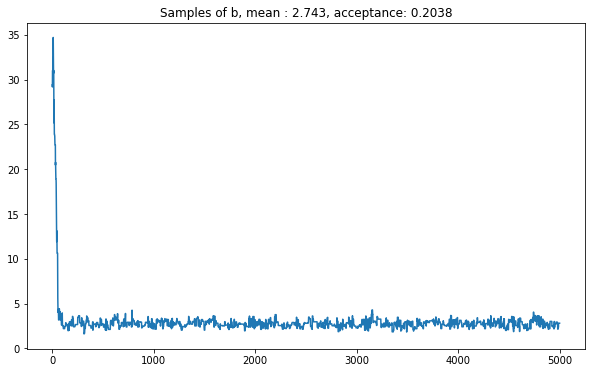

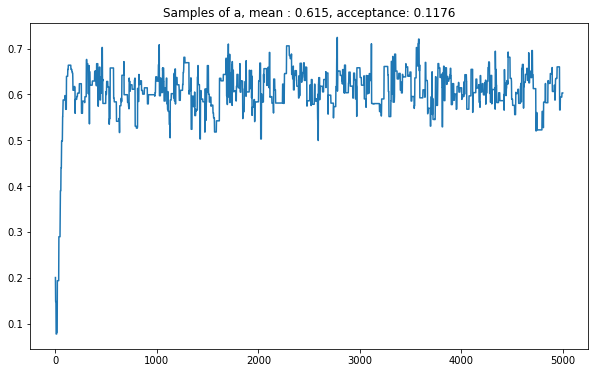

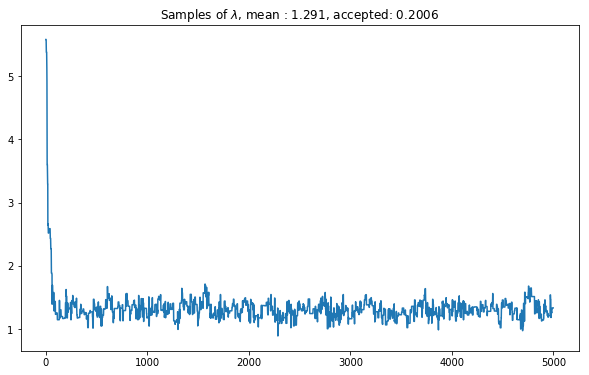

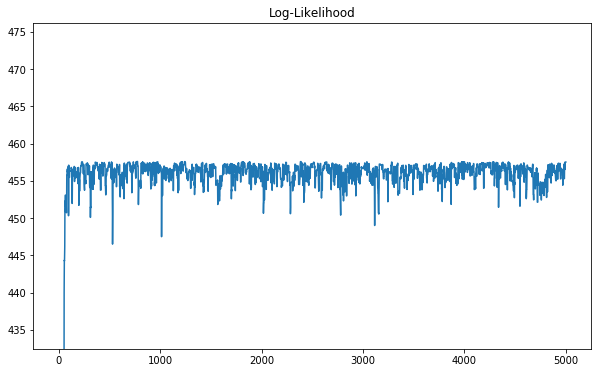

In [126]:
# PARAMETER ESTIMATION FOR SIMULATED DATA
sim_Hawkes_train = simulated_Hawkes
samples_lmbd, samples_a, samples_b = Hawkes_MH_within_Gibbs(350, sim_Hawkes_train, 0.5, 0.3, 2, 5000, alpha_lmbd=1, 
                                                            beta_lmbd=0.05, alpha_b=1, beta_b = 0.05)

In [155]:
predictive_likelihood([1.4], [0.6], [3], sim_Hawkes_train, 
                      simulated_Hawkes, 350, 250, L=1000) 

0.11510231341723826

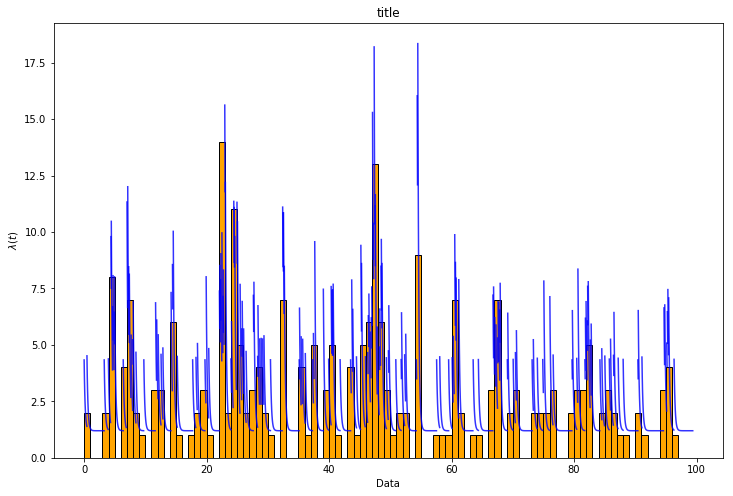

In [18]:
plot_fitted_CIF(np.mean(samples_lmbd), np.mean(samples_a), np.mean(samples_b), arrivals, 100, 'simulated', step=1)

For every (different) simulation, the algorithm converges, in some cases the estimates are good, others are worse. For each simulated realization I tried, the algorithm's convergence is invariant to starting values. 

### TO DO : so far I have three spiking datasets:
Disjk & Fenton - which I don't understand where they come from

Timme et al - documented, probably not the type of neurons I want

Frank et al - documented, need to open the .gz archive file

### Mitchell et al - [DATA](https://snl.salk.edu/~jude/neuron_exchange/index.html)

In [ ]:
# Use this block to open data files
T_Mitchell = 460
mitchell_mzir50u1 = []
mitchell_dir = r"C:\Users\ad15865\OneDrive - University of Bristol\Documents\Downloads\Mitchell et al - Data\mzir50u1_t"
for i in range(1,15):
    file = open(mitchell_dir+str(i)+'.csv', 'r')
    lines = file.readlines()
    times = np.array([float(entry) for entry in lines[0].split(',') if float(entry)>=0])/10
    mitchell_mzir50u1.append(times)

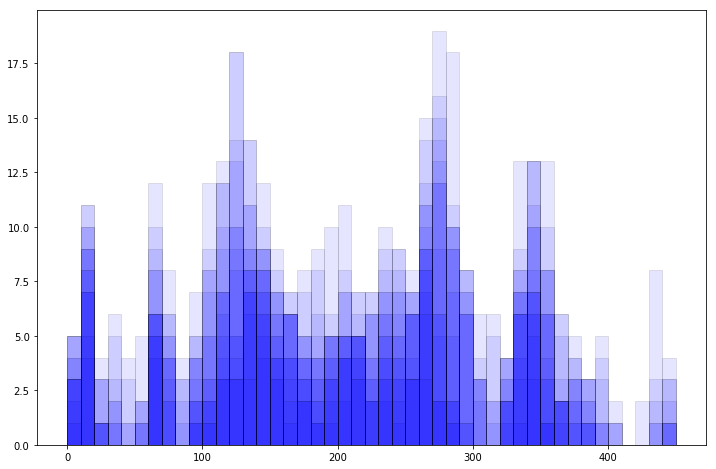

In [94]:
plt.figure(figsize=(12,8))
for data in mitchell_mzir50u1:
    plt.hist(data, ec='black', bins=np.arange(0,460,10), alpha=0.1, color='blue')

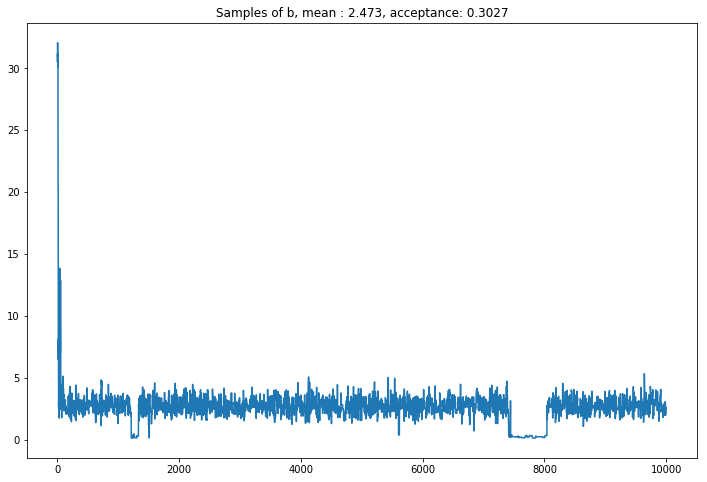

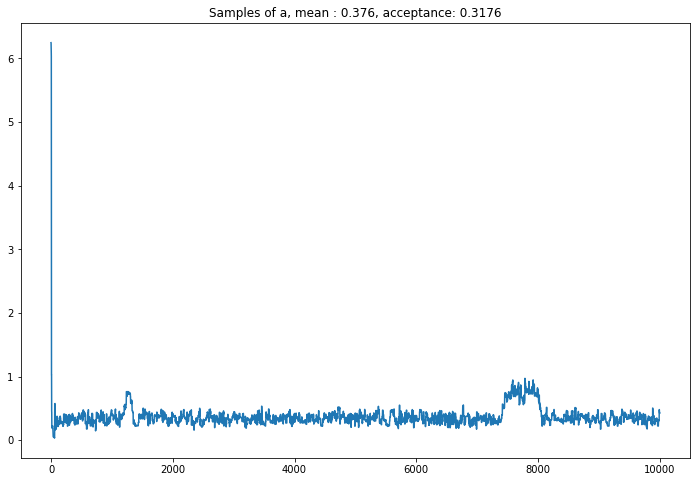

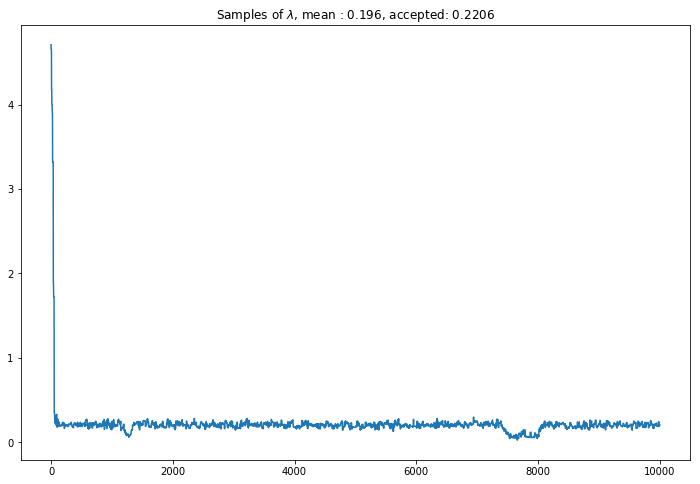

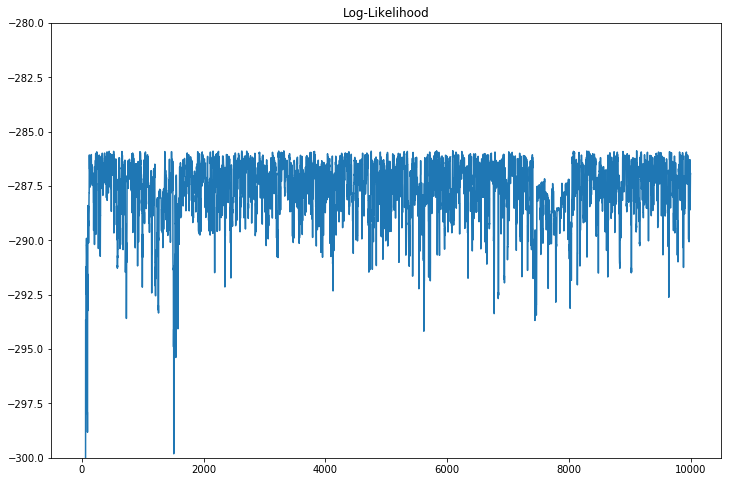

In [162]:
file = open(r"C:\Users\ad15865\OneDrive - University of Bristol\Documents\Downloads\Mitchell et al - Data\mzir22u2_t4.csv",'r')
mzir22u2_t4 = np.array([float(entry) for entry in lines[0].split(',') if float(entry)>=0])/10
_, _, _ = Hawkes_MH_within_Gibbs(460, mzir22u2_t4, 0.1, 1, 2, 10000, alpha=1, beta=0.05, alpha_b=1, beta_b=0.05)

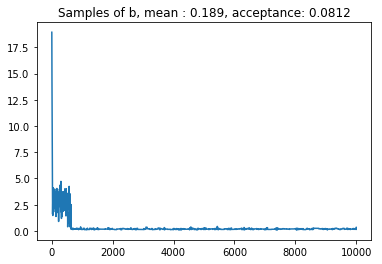

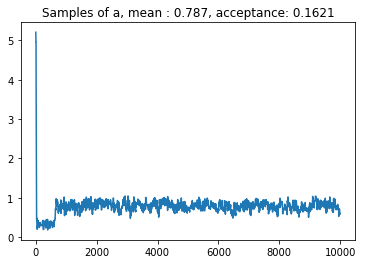

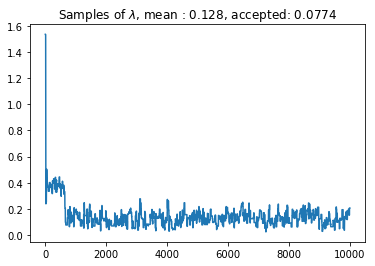

In [45]:
lmbd1, a1, b1 = Hawkes_MH_within_Gibbs(456, times1, 0.5, 0.5, 1, 10000, alpha=1, beta=0.05, alpha_b=1, beta_b=0.05)

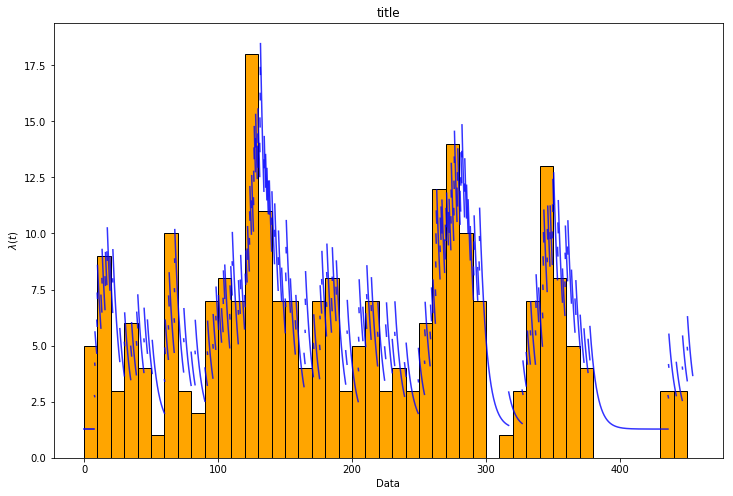

In [52]:
plot_fitted_CIF(np.mean(lmbd1), np.mean(a1), np.mean(b1), times1, 456, 'Mitchell mzir50u1_t1', step=10)

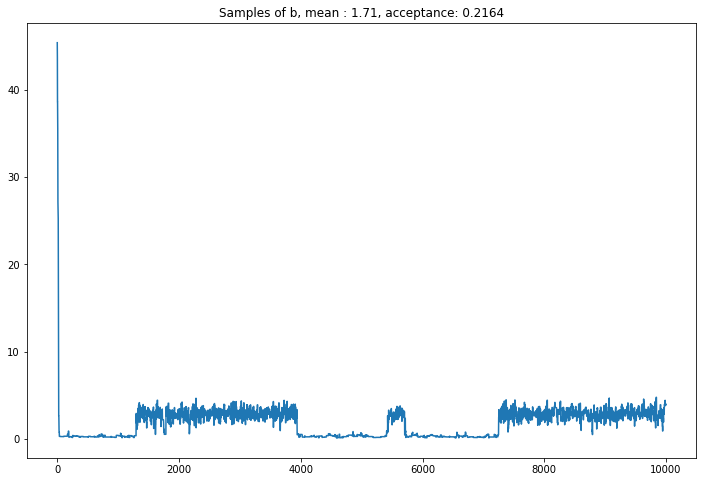

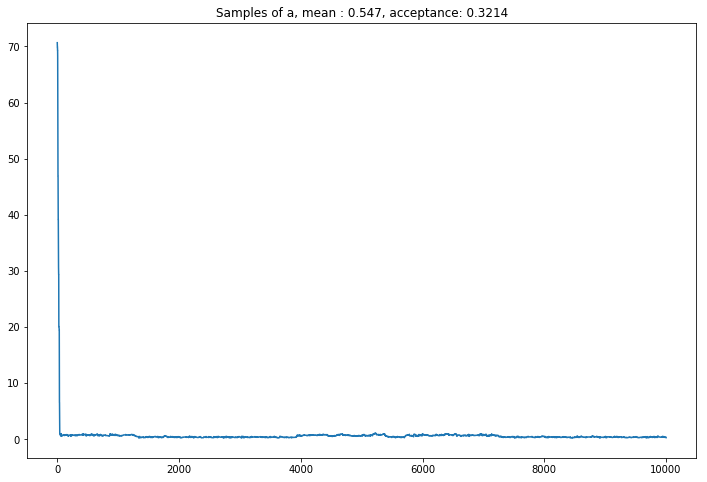

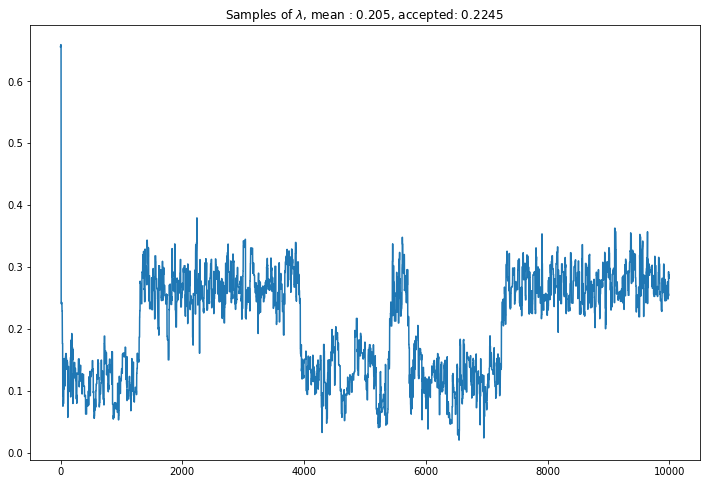

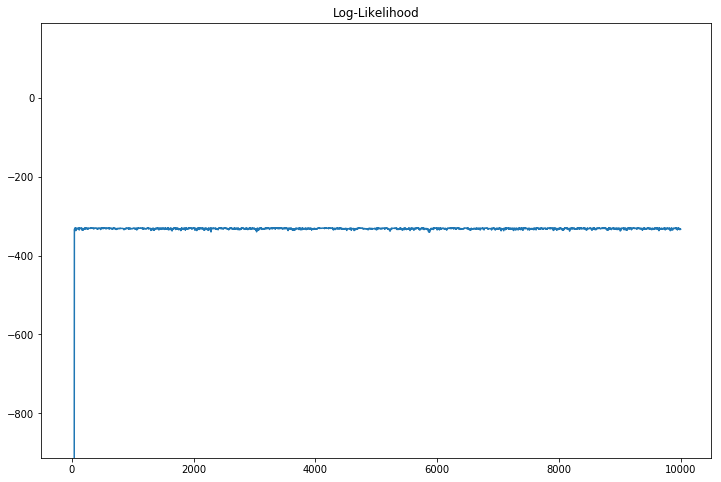

In [34]:
lmbd3, a3, b3 = Hawkes_MH_within_Gibbs(460, mitchell_mzir50u1[2], 0.5, 0.5, 0.5, 10000, alpha_b=1, beta_b=0.05, alpha=1, beta=0.05)

334.7340451734574


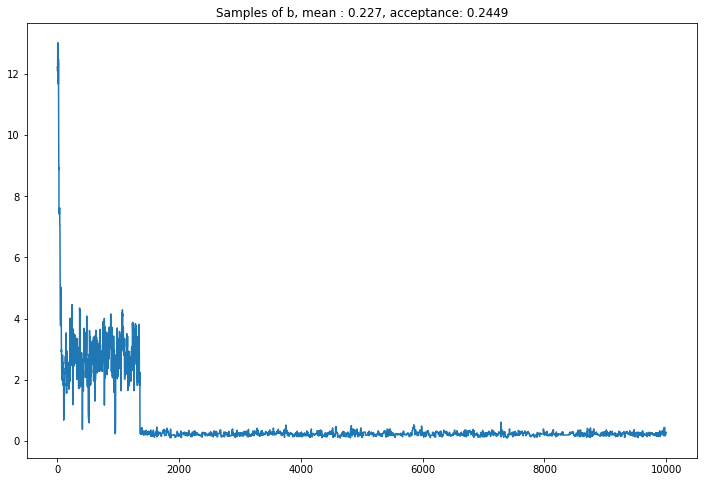

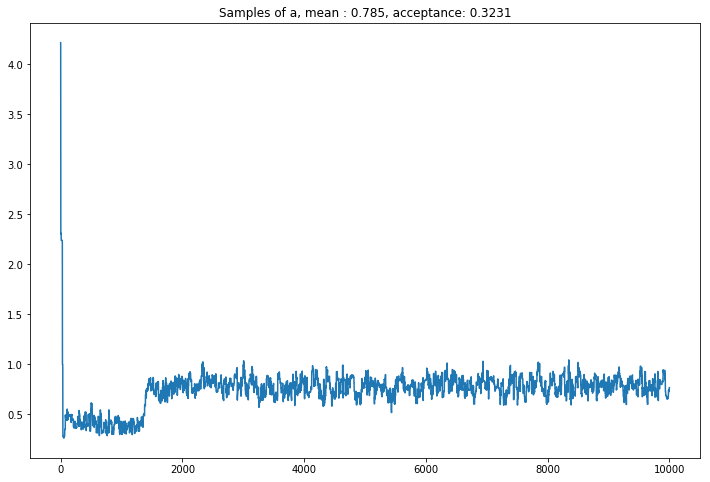

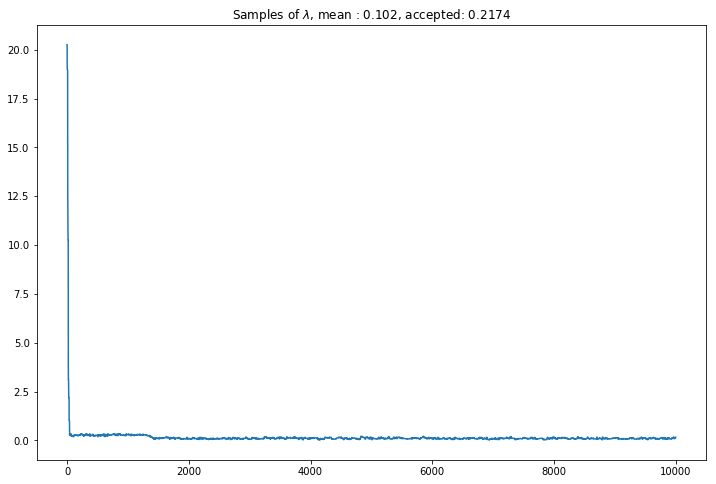

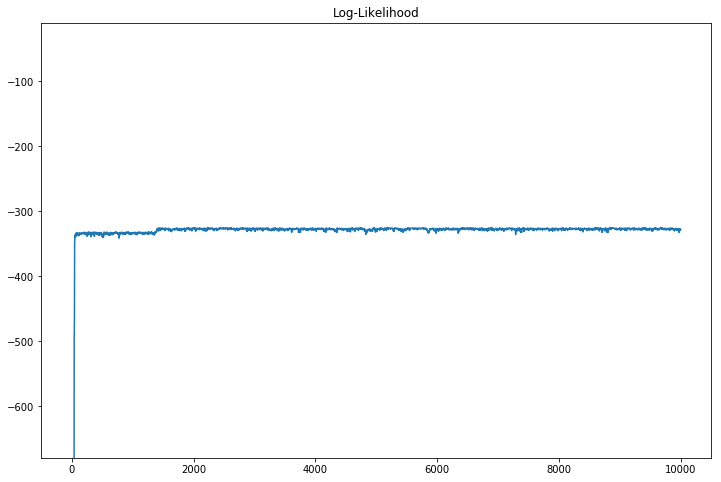

In [45]:
lmbd5, a5, b5 = Hawkes_MH_within_Gibbs(460, mitchell_mzir50u1[4], 0.5, 0.5, 1, 10000, alpha_b=1, beta_b=0.05, alpha=1, beta=0.05)

In [52]:
test = mitchell_mzir50u1[1]
predictive_likelihood(np.mean(lmbd5), np.mean(a5), np.mean(b5), mitchell_mzir50u1[4], test, 460, 460)

0.6104401843245238

In [ ]:
lmbd7, a7, b7 = Hawkes_MH_within_Gibbs(max(times7), times7, 0.5, 0.5, 0.5, 10000, alpha_b=1, beta_b=0.05, alpha=1, beta=0.05)

### Lefebvre DATA

In [11]:
lef_606r3_1 = open(r"C:\Users\ad15865\OneDrive - University of Bristol\Documents\Downloads\Lefebvre DATA\606R3_1.csv", 'r')
lines = lef_606r3_1.readlines()
lef_606r3_1.close()
lef_606r3_1 = [float(entry) for entry in lines]

In [77]:
lef_606r3_2 = open(r"C:\Users\ad15865\OneDrive - University of Bristol\Documents\Downloads\Lefebvre DATA\606R3_2.csv", 'r')
lines = lef_606r3_2.readlines()
lef_606r3_2.close()
lef_606r3_2 = [float(entry) for entry in lines]
lef_606r3_2[100]

17.185

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


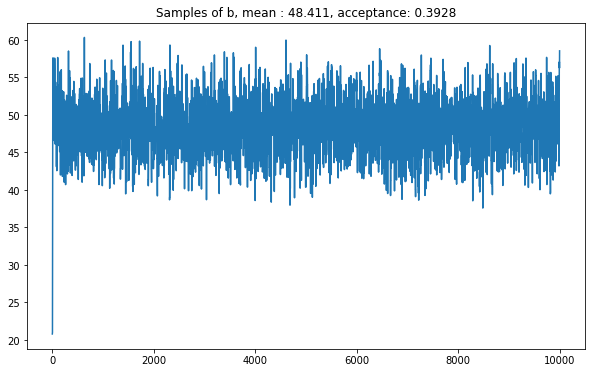

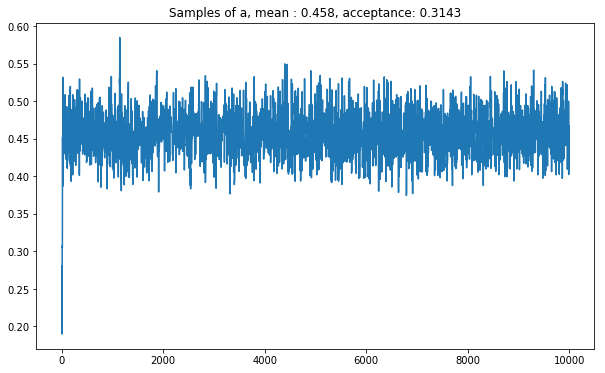

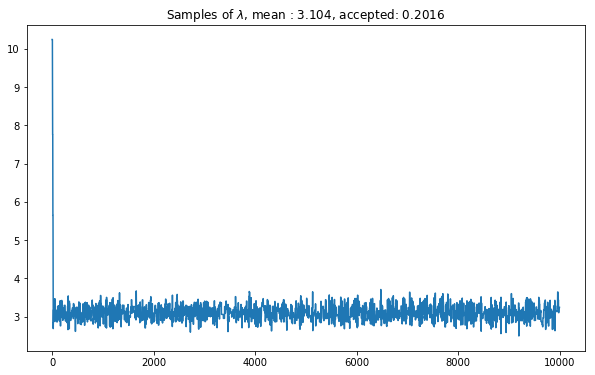

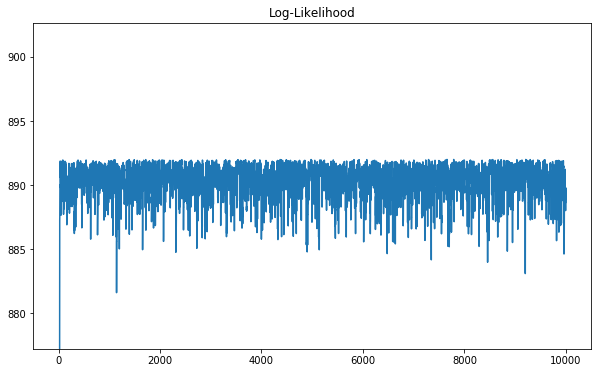

In [31]:
lef_lmbd1, lef_a1, lef_b1 = Hawkes_MH_within_Gibbs(140, lef_606r3_1[:800], 1, 0.1, 10, 10000, alpha_b=1, beta_b=0.05, 
                                                   alpha_lmbd=1, beta_lmbd=0.05)

In [ ]:
plt.figure(figsize=(16,8))
plt.scatter(lef_606r3_1[:300], np.ones((300,)), alpha=0.1)
plt.title('lef_606r3_1')

(array([25., 12., 20., 13., 15., 20., 20., 18., 21., 13., 18., 20., 19.,
        16., 18., 15., 21., 16., 15., 17., 22., 14., 17., 13., 16., 16.,
        20., 20., 16., 20., 14., 22., 15., 15., 16., 17., 16., 17., 17.,
        15., 16., 19., 16., 16., 20., 18.]),
 array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
         39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,
         78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114,
        117, 120, 123, 126, 129, 132, 135, 138]),
 <a list of 46 Patch objects>)

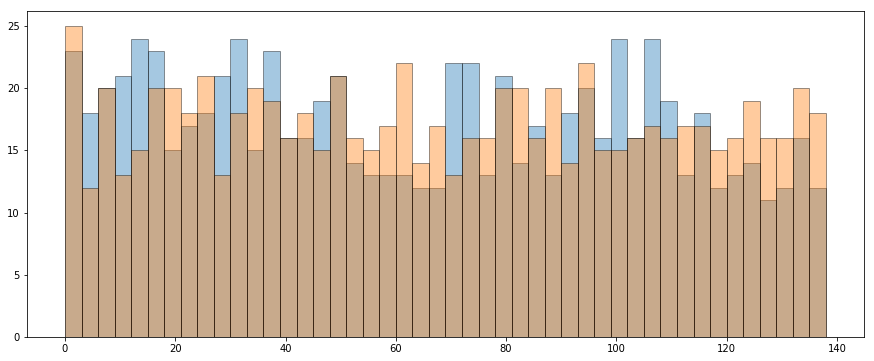

In [72]:
plt.figure(figsize=(15,6))
bins = np.arange(0, 140, 3)
plt.hist(lef_606r3_1[:800], alpha=0.4, ec='black', bins=bins)
plt.hist(lef_606r3_2[:806], alpha=0.4, ec='black', bins=bins)

## Different model? Latent Variable

In [25]:
def sample_omega(lmbd, a, b, arrivals, T):
    samples = []
    for i in range(len(arrivals)):
        if i==0:
            samples.append(0)
        else:
            support = [lmbd]
            for j in range(i):
                support.append(a*b*np.exp(-b*(arrivals[i]-arrivals[j])))
            samples.append(np.random.choice(range(i+1), p = np.array(support)/np.sum(support)))
    return np.array(samples)

In [29]:
# All functions in this block are used specifically for the Latent Hawkes model.

import warnings
warnings.simplefilter("error")

def prod_for_b(b, arrivals, t_n, n, omega):
    output = 0.0
    for j in range(n, len(arrivals)):
        if omega[j]==n:
            output += np.log(b) - b*(arrivals[j]-t_n)
    return output
    #return np.sum([(omega[j]==index_t_n)*np.log(b*np.exp(-b*(arrivals[j]-t_n))) for j in range(len(arrivals))])

def LatHawkes(T, arrivals, alpha_lmbd, beta_lmbd, alpha_a, beta_a, alpha_b, beta_b, scale_b, N=10000):
    
    curr_lmbd = gamma.rvs(a=alpha_lmbd, scale=1/beta_lmbd)
    curr_a = gamma.rvs(a=alpha_a, scale=1/beta_a)
    curr_b = gamma.rvs(a=alpha_b, scale=1/beta_b)
    curr_omega = sample_omega(curr_lmbd, curr_a, curr_b, arrivals, T)
    
    accepted_b = 0.0
    samples_lmbd, samples_a, samples_b = [], [], []
    
    for i in range(N):
        # First update lambda
        cand_lmbd = gamma.rvs(a=alpha_lmbd+np.sum(curr_omega==0), scale=1/(beta_lmbd+T))
        curr_lmbd = cand_lmbd
        samples_lmbd.append(curr_lmbd)

        # Update b
        cand_b = norm.rvs(loc=0, scale=scale_b) + curr_b
        if cand_b>0:
            b_post_at_curr = np.sum([curr_a*(np.exp(-curr_b*(T-arrivals[n]))-1)+prod_for_b(
                curr_b, arrivals, arrivals[n], n+1, curr_omega) for n in range(len(arrivals))]) + gamma.logpdf(
            curr_b, a=alpha_b, scale=1/beta_b)
            b_post_at_cand = np.sum([curr_a*(np.exp(-cand_b*(T-arrivals[n]))-1)+prod_for_b(
                cand_b, arrivals, arrivals[n], n+1, curr_omega) for n in range(len(arrivals))]) + gamma.logpdf(
            cand_b, a=alpha_b, scale=1/beta_b)
            ratio1 = min(0, b_post_at_cand - b_post_at_curr)
            U = uniform.rvs()
            if U <= np.exp(ratio1):
                curr_b = cand_b
                accepted_b += 1
        samples_b.append(curr_b)

        # Update a
        new_alpha = np.sum([np.sum(curr_omega==j+1) for j in range(len(arrivals))])
        new_beta = np.sum([1-np.exp(-curr_b*(T-t)) for t in arrivals])
        cand_a = gamma.rvs(a=new_alpha + alpha_a, scale = 1/(new_beta + beta_a))
        curr_a = cand_a
        samples_a.append(curr_a)

        # Update omega
        cand_omega = sample_omega(curr_lmbd, curr_a, curr_b, arrivals, T)
        curr_omega = cand_omega
        
        if i%1000==0:
            print(i)
    
    plt.figure(figsize=(10,6))    
    plt.plot(range(N), samples_b)
    plt.title('Samples of b, mean : {}, acceptance: {}'.format(round(np.mean(samples_b[int(N/3):]),3), accepted_b/N))
    plt.figure(figsize=(10,6))
    plt.plot(range(N), samples_a)
    plt.title('Samples of a, mean : {}'.format(round(np.mean(samples_a[int(N/3):]),3)))
    plt.figure(figsize=(10,6))
    plt.plot(range(N), samples_lmbd)
    plt.title('Samples of $lambda$, mean : {}'.format(round(np.mean(samples_lmbd[int(N/3):]),3)))
    return samples_lmbd[int(N/3):], samples_a[int(N/3):], samples_b[int(N/3):]

0
1000
2000
3000


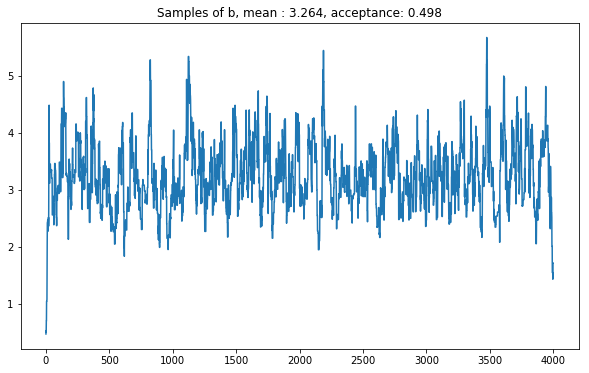

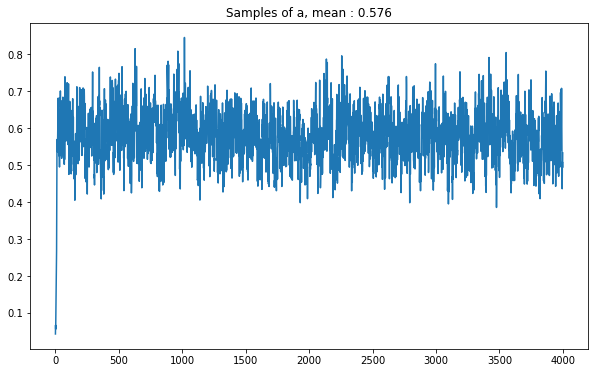

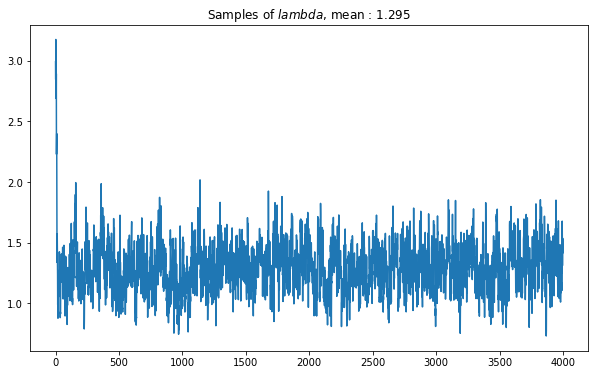

In [32]:
sim_lmbd, sim_a, sim_b = LatHawkes(100, simulated_Hawkes, 1, 0.05, 4, 8, 1, 0.05, scale_b=0.5, N=4000)

In [33]:
np.var(samples_lmbd), np.var(samples_a), np.var(samples_b)

(0.035209351624405, 0.004163154704611614, 0.33260887406176176)

In [34]:
np.var(sim_lmbd), np.var(sim_a), np.var(sim_b)

(0.033981459107933244, 0.003924775544314064, 0.3114234635843665)

In [211]:
mitchell_lat_lmbd1, mitchell_lat_a1, mitchell_lat_b1 = LatHawkes(460, mitchell_mzir50u1[0], 1, 0.05, 4, 8, 1, 
                                                                 0.05, scale_b=1.5, N=5000)

0
1000


KeyboardInterrupt: 

Exception ignored in: <_io.FileIO name='C:\\Users\\ad15865\\OneDrive - University of Bristol\\Documents\\Downloads\\Timme et al - Data\\timme_div6n1.csv' mode='rb' closefd=True>


0
1000
2000


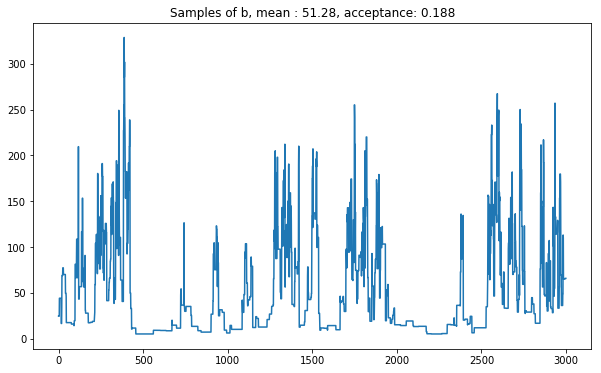

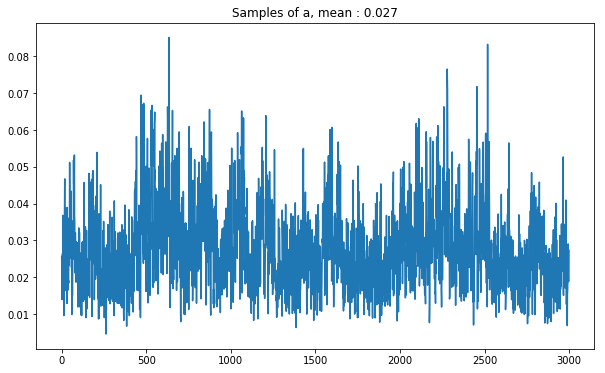

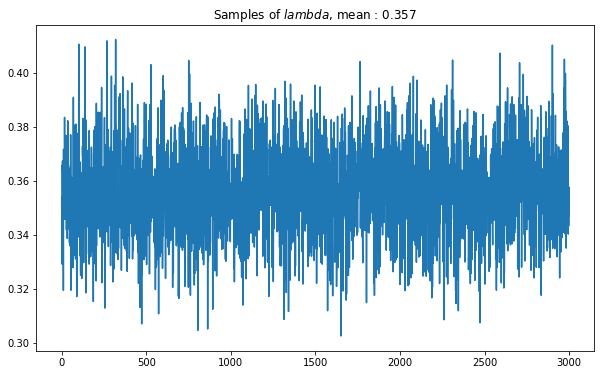

In [39]:
file = open(r"C:\Users\ad15865\OneDrive - University of Bristol\Documents\Downloads\Timme et al - Data\timme_div6n1.csv")
lines = file.readlines()
timme = [float(entry)/100 for entry in lines[0].split(',')]
timme_lat_lmbd, timme_lat_a, timme_lat_b = LatHawkes(1380, timme[:500], 1, 0.05, 4, 8, 1, 0.05, scale_b=100, N=3000)